# HackDartmouth IV - QSS Data Science Challenge
In this notebook, we will load the training data and perform preliminary processing and analysis before we start training. 

From the challenge prompt, we know the following:
- Development set: 749,575 Yelp reviews
- Evaluation set: 250,425 Yelp reviews
- Challenge: predict **review star ratings**
- Avaliable features:
    + business_id
    + cool
    + date
    + funny
    + review_id
    + text
    + useful
    + user_id

In [1]:
# Basic Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
## Load Dataset
fname = 'yelp.json'
df    = pd.read_json('yelp.json')

print 'Total number of entries: {}'.format(len(df))

Total number of entries: 749574


### Notes on Features
- **review_id**: all review ids are unique, hence can remove entire column
- **business_id**: only 123,553 unique entries
- **user_id**: only 221,465 unique entries

In [3]:
# Convert Select Cols to categories 
catcols = ['business_id','user_id']
for col in catcols:
    df[col] = df[col].astype('category')

In [4]:
df['user_id'] = df.user_id.cat.codes
df['business_id'] = df.business_id.cat.codes

In [5]:
# Include Normalized Date
# Using month, day & year
df['month'] = df.date.dt.month
df['day']   = df.date.dt.day
df['year']  = df.date.dt.year
df['dOw']   = df.date.dt.dayofweek
df.drop(columns=['date'])

cols  = ['business_id','user_id','review_id',
         'year','month','day','dOw','cool',
         'funny','useful','text','stars']
df    = df[cols]

In [6]:
df.head()

business_id  user_id               review_id  year  month  day  dOw  cool  \
0         2956   138470  v0i_UHJMo_hPBq9bxWvW4w  2016      5   28    5     0   
1        21735   138470  vkVSCC7xljjrAI4UGfnKEQ  2016      5   28    5     0   
2        62880   138470  n6QzIUObkYshz4dz2QRJTw  2016      5   28    5     0   
3        25756   138470  MV3CcKScW05u5LVfF6ok0g  2016      5   28    5     0   
4        21657   138470  IXvOzsEMYtiJI0CARmj77Q  2016      5   28    5     0   

   funny  useful                                               text  stars  
0      0       0  Love the staff, love the meat, love the place....      5  
1      0       0  Super simple place but amazing nonetheless. It...      5  
2      0       0  Small unassuming place that changes their menu...      5  
3      0       0  Lester's is located in a beautiful neighborhoo...      5  
4      0       0  Love coming here. Yes the place always needs t...      4

Text(0.5,1,u'Class Distribution')

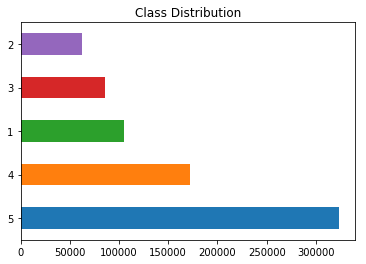

In [7]:
# Class Distribution
df['stars'].value_counts().plot(kind='barh')
plt.title('Class Distribution')

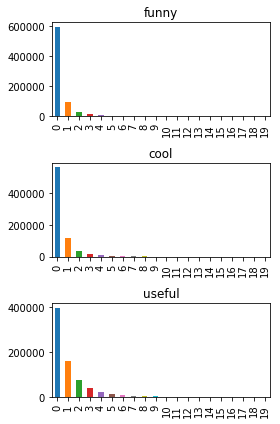

In [8]:
# Distribution of Other Features
catcols = ['funny', 'cool','useful']

plt.figure(figsize=(4,6))
for i,col in enumerate(catcols):
    plt.subplot(311+i)
    df[col].value_counts()[:20].plot(kind='bar')
    plt.title(col)
plt.tight_layout()

## Using Doc2Vec To Vectorize

In [9]:
vmodel = Doc2Vec.load('doc2vec25.model')
ids = df.review_id.values

In [10]:
# Get Vectorized texts
v_data = []
for i in range(len(ids)):
    v = vmodel.docvecs[i]
    v_data.append(v)

In [11]:
v_data = np.vstack(v_data)

In [12]:
fcols  = ['business_id','user_id','year','month','day','dOw','cool','funny','useful']
x_data = df[fcols].values
x_data = np.append(x_data,v_data,axis=-1)
y_data = df['stars'].values

In [13]:
x_data.shape

(749574, 41)

In [14]:
y_data.shape

(749574,)

In [ ]:
# Split into Train & Validation
xtrain,xvalid,ytrain,yvalid = train_test_split(x_data,y_data,
                                             test_size=0.33,random_state=32)

print 'Size of Train set: {}'.format(len(xtrain))
print 'Size of Valid set: {}'.format(len(xvalid))

## Training & Evaluation

In [15]:
# Training on Full Dataset
model = XGBClassifier(n_estimators=300,njobs=4,
                      objective='multi:softmax',num_class=5)
model.fit(x_data,y_data)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, njobs=4, nthread=None, num_class=5,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [ ]:
k = 10000

# Training & Evaluation
print '\nTraining & evaluating model...'
# Fit model no training data
model = XGBClassifier(n_estimators=300,njobs=4,
                      objective='multi:softmax',num_class=5)
model.fit(xtrain, ytrain)
ypred = model.predict(xvalid)
ypred = [round(value) for value in ypred]

# evaluate predictions
acc   = accuracy_score(yvalid, ypred)
print("Accuracy: %.2f%%" % (acc * 100.0))

In [ ]:
plt.hist(ypred)

In [ ]:
plt.hist(yvalid[:k])

# On Test Set for Submission

In [16]:
## Load Test Set
dt    = pd.read_json('yelpHeld.json')
for col in ['business_id','user_id']:
    dt[col] = dt[col].astype('category')

dt['user_id'] = dt.user_id.cat.codes
dt['business_id'] = dt.business_id.cat.codes

In [17]:
dt['month'] = dt.date.dt.month
dt['day']   = dt.date.dt.day
dt['year']  = dt.date.dt.year
dt['dOw']   = dt.date.dt.dayofweek
dt.drop(columns=['date'])
dt.head()

business_id  cool       date  funny               review_id  \
0        67225     0 2016-05-28      0  L_9BTb55X0GDtThi6GlZ6w   
1         8152     0 2013-02-09      0  w41ZS9shepfO3uEyhXEWuQ   
2        75775     0 2013-05-01      0  PIsUSmvaUWB00qv5KTF1xA   
3        41556     1 2011-09-28      0  PdZ_uFjbbkjtm3SCY_KrZw   
4        34642     1 2012-12-03      1  lsoSqIrrDbQvWpMvsSj2xw   

                                                text  useful  user_id  month  \
0  Had their chocolate almond croissant and it wa...       0    71193      5   
1  Not bad!! Love that there is a gluten-free, ve...       1   103236      2   
2  This is currently my parents new favourite res...       1   103236      5   
3  Server was a little rude.\n\nOrdered the calam...       5   103236      9   
4  Wanted to check out this place due to all the ...       2   103236     12   

   day  year  dOw  
0   28  2016    5  
1    9  2013    5  
2    1  2013    2  
3   28  2011    2  
4    3  2012    0

In [18]:
# Get Texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

In [19]:
data  = dt.text.values
label = dt.review_id.values

tokenizer = RegexpTokenizer(r'\w+')
stopset   = set(stopwords.words('english'))

In [20]:
docs      = []
for i in range(len(data)):
    tag    = label[i]
    words  = data[i].lower()
    words = tokenizer.tokenize(words)
    words = [w for w in words if not w in stopset]
    docs.append(words)
#     docs.append(TaggedDocument(tokens,[str(tag)]))

In [21]:
# Get doc2vec features of test set
v_data = [vmodel.infer_vector(doc) for doc in docs]

In [22]:
# Append to other features
v_data = np.vstack(v_data)
x_data = dt[fcols].values
x_data = np.append(x_data,v_data,axis=-1)

In [23]:
# Finally predict
ypred = model.predict(x_data)
ypred = [int(value) for value in ypred]

/home/junior/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
ypred[:5]

[5, 4, 4, 4, 4]

In [25]:
review_id = dt.review_id.values.tolist()

In [26]:
csvname='allsubmission.csv'
ds = pd.DataFrame({'review_id': review_id,
                   'stars'    : ypred})
ds.to_csv(csvname,index=False)
print 'Submission file saved as ' + csvname

Submission file saved as allsubmission.csv
